In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='ticks', palette='Set2')
import pandas as pd
import numpy as np
import math
from __future__ import division

### Supervised learning example: Iris data

* inputs: measurements of flowers, outputs/class labels: iris flower type
* More info: http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
* evaluate with Naive Bayes
* evaluate with sklearn logistic regression
* evaluate with custom logistic regression

### What is involved?

* statistics
* convex optimization (gradient descent)
* linear algebra
* calculus (first derivative, though with logistic regression, it's really easy)

## 1.) Run the next 3 cells to get a feel for the data. 

In [2]:
#
#    load the iris data
#
# The iris dataset contains 4 attributes for 3 types of iris plants. 
# The purpose is to classify which plant you have just based on the attributes. 
# To simplify things, we will only consider 2 attributes and 2 classes. Here are the data visually:
#

data = datasets.load_iris()
X = data.data[:150, :3]
y = data.target[:150]
X_full = data.data[:150, :]
print(y[10:20])
X[10:20] # show the first ten samples

[0 0 0 0 0 0 0 0 0 0]


array([[5.4, 3.7, 1.5],
       [4.8, 3.4, 1.6],
       [4.8, 3. , 1.4],
       [4.3, 3. , 1.1],
       [5.8, 4. , 1.2],
       [5.7, 4.4, 1.5],
       [5.4, 3.9, 1.3],
       [5.1, 3.5, 1.4],
       [5.7, 3.8, 1.7],
       [5.1, 3.8, 1.5]])

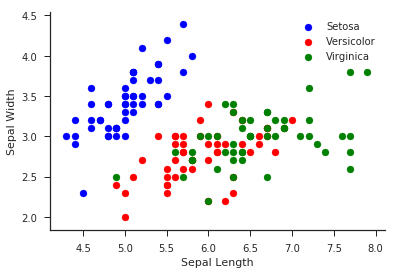

In [3]:
#
#  plot the iris sepal width and sepal lengths
#
setosa = plt.scatter(X[:50,0], X[:50,1], c='b')
versicolor = plt.scatter(X[50:100,0], X[50:100,1], c='r')
virginica = plt.scatter(X[100:150,0], X[100:150,1], c='g')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend((setosa, versicolor, virginica), ("Setosa", "Versicolor", "Virginica"))
sns.despine()

In [4]:
#
#   train and evaluate a Naive Bayes Classifier from scikit-learn, calculate accuracy
#   our logistic regression classifier should do better
# 

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(data.data, data.target).predict(data.data)
100 * (1.0 - ((data.target != y_pred).sum()/data.data.shape[0]))

96.0

## 2.) Run the cell below to plot the logit function in 2 dimensions. 

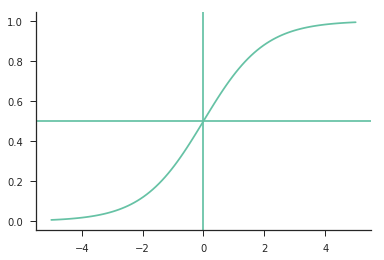

In [5]:
x_values = np.linspace(-5, 5, 100)
y_values = [1 / (1 + math.e**(-x)) for x in x_values]
plt.plot(x_values, y_values)
plt.axhline(.5)
plt.axvline(0)
sns.despine()

## 3.) Write a function `logistic_fuction` 

*  `theta` starts off as a vector of three zeros `[0,0,0]`. As gradient descent progresses, these values will change. 
* `x` is the training data 
* return the calculated logit (see 2 for an example of this in 2D)

**Hints**

* you will probably use a dot product

In [6]:
def logistic_func(theta, x):
    return np.array([1/(1 + math.e ** -np.dot(theta, x_cur)) for x_cur in x])

## 4.) Write a function `log_gradient`

* `theta` starts off as a vector of three zeros `[0,0,0]`. As gradient descent progresses, these values will change. 
* `x` is the training data 
* `y` is the set of labels
* return the log gradient

**Hints**

* you will call `logistic_func` somewhere
* you will probably use a dot product somewhere
* you will porobably use a transpose somewhere
* you might try using `np.squeeze(y)`

In [7]:
# We are trying to maximize the likelihood. However, for the logistic function, the
# likelihood function is a repeated product based on the number of rows in the data set,
# not a repeated sum, which makes it hard to compute the gradient, as the gradient
# requires taking derivatives, and each row of the data set would chain the derivative
# to be more complicated by the product rule:
# d/dx(f(x) * g(x)) = f(x) * d/dx(g(x)) + d/dx(f(x)) * g(x)
# However, since this function is monotonically increasing as is the log function, we
# can use the log likelihood as a stand-in for the likelihood. This allows us to use
# log rules to convert the repeated product to a repeated sum, for which the derivative
# is easier to compute.
#
# The log likelihood is defined as:
# C = N^(-1)*sum(log(h_theta(x_i)^(y_i)*(1-h_theta(x_i))^(y_i)))
# Note that we usually normalize the likelihood or log likelihood, but the gradient
# should not be normalized.
# Computing the derivative partial derivatives, we have:
# grad(C) = sum(
# [x_1] * (e_term*logit*(-y + logit*(1-y)/(1-logit)))
# [x_2]
# [...]
# [x_n]
# )
# where each term of the sum is a row in the data set (x_1, x_2, ... , x_n, y), e_term
# is e^(-theta*x) where theta is the coefficient vector and x is the independent variable
# vector, and logit is the logistic function.
# which further simplifies to:
# grad(C) = sum(
# [x_1] * (logit - y)
# [x_2]
# ...
# [x_n]
# )
# (Thanks Sujeet!)
import math
def log_gradient(theta, x, y):
    # Tried to us np.sum so we wouldn't have to use a loop, but that was returning something funky
    accum = [0.0 for theta_cur in theta]
    for x_cur, y_cur, l_f_cur in zip(x, np.squeeze(y), logistic_func(theta, x)):
        accum += (l_f_cur - y_cur) * x_cur
    return accum

## 5.) Insert the following comments into the correct lines of code in the 2 functions below:

* `#normalize`
* `#this loop actually performs the gradient descent by moving the regression line until the cost change is very small`
* `#calculate the change in the coefficients`
* `#calculate the change in the cost`
* `#initialize the change in cost to a high value`

In [8]:
def cost_func(theta, x, y):
    '''
    computes the cost function; i.e., (for linear regression) minimize the distance between a regression line
    and all of the points
    '''
    log_func_v = logistic_func(theta,x)
    y = np.squeeze(y)
    step1 = y * np.log(log_func_v)
    step2 = (1-y) * np.log(1 - log_func_v)
    final = -step1 - step2
    return np.mean(final)

def grad_desc(theta_values, X, y, lr=.001, converge_change=.001):
    '''
    the hard part of learning: gradient descent. Fortunately, the logistic function is convex --
    the derivitive is itself
    '''
    #normalize
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0) 
    #setup cost iter
    cost_iter = []
    cost = cost_func(theta_values, X, y)
    cost_iter.append([0, cost])
    #initialize the change in cost to a high value
    change_cost = 1 
    i = 1
    
    #this loop actually performs the gradient descent by moving the regression line until the cost change is very small
    while(change_cost > converge_change):
        old_cost = cost
        #calculate the change in the coefficients
        theta_values = theta_values - (lr * log_gradient(theta_values, X, y)) # the cost change
        cost = cost_func(theta_values, X, y)
        cost_iter.append([i, cost])
        #calculate the change in the cost
        change_cost = old_cost - cost 
        i+=1
    return theta_values, np.array(cost_iter)

## 6.) Run the following cell.

In [9]:
# Expected array([-3.91547066,  5.42219164, -6.72251116])
shape = X.shape[1]
y_flip = np.logical_not(y) #flip Setosa to be 1 and Versicolor to zero to be consistent
betas = np.zeros(shape) #start off with zeros for the coefficients
fitted_values, cost_iter = grad_desc(betas, X, y_flip,  lr=.1)
fitted_values

array([-3.91547066,  5.42219164, -6.72251116])

## 7.) Plot the cost over iterations

**Hints**

* you will use the `cost_iter` variable from the above cell

0.025397516830651518


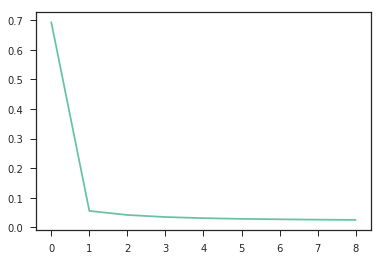

In [10]:
print(str(cost_iter[len(cost_iter)-1][1]))
plt.plot(cost_iter[:, 0], cost_iter[:, 1])

## 8.) Run the following cell and answer the questions below. 

In [11]:
# Expected 0.99333333333333329
def pred_values(theta, X, hard=True):
    '''
    predictor values
    '''
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0) #normalize
    pred_prob = logistic_func(theta, X)
    pred_value = np.where(pred_prob >= .5, 1, 0) # note the threshold of 0.5
    if hard:
        return pred_value
    return pred_prob

predicted_y = pred_values(fitted_values, X)
np.sum(y_flip == predicted_y) / 150.0

0.9933333333333333

#### 1.) What is the accuracy of your logistic regression classifier?

99.3...%

####  2.) What happens if you change the learning rate (i.e., ` lr=.001`) to a smaller value like `0.01` and `0.1`? What do you notice about the plot in 7 and the accuracy in the cell below? 

With the learning rate slower, the coefficients traverse the gradient slower, so the cost function doesn't approach a local minimum as quickly. After enough learning sessions, it gets to a local minimum *eventually*. The accuracy at this local minimum is a little lower, though (98% for lr=0.001).

####  3.) Why do you think the accuracy changes?

Notice that the fitted theta coefficients with lr=0.001 are much different than the fitted theta coefficients with lr=0.1. With a lower learning rate, the gradient descent will be less likely to "hop" to another local minimum. If there are multiple "dips" in the cost function, different learning rates may find different dips.

I collaborated a bit with Sam, and we brainstormed that it could also be that if our learning rate is extremely small compared to the cost change at which to stop the descent and the cost curve is sufficiently flat at that point, the gradient descent could get stuck at a point that isn't even a minimum, because a very small gradient vector could translate into a very small cost change if the curve is sufficiently flat at that position. This could be alleviated if converge_change was calculated in terms of lr.

## 9.) Run the following cell to compare your classifier to scikit-learn's logistic regression classifier. Answer the questions below. 

In [12]:
# Expected 1.0
from sklearn import linear_model
logreg = linear_model.LogisticRegression()
logreg.fit(X, y_flip)
sum(y_flip == logreg.predict(X)) / 150.0

1.0


#### Which logistic regression classifier worked better? Why do you think that is?

Scikit's is 1.0, so it's a little better. Scikit may have found a better local minimum than our classifier. Maybe instead of training the model from one initial theta vector, they tried training the model with several initial theta vectors and picked the one which minimized the cost.

#### For this task, why do you think the logistic regression classifier works better than the Naive Bayes classifier?

Based on what I've read, it sounds like the Naive Bayes Classifier is better suited for discrete probability distributions, like NLP. The features of the irises are continuous, though.

In addition, the NBC makes independence assumptions between all features, but it is very likely that some of the features of the irises are correlated with each other. For example, I would not be surprised if the petal width is correlated with the petal length. The logistic model is a general linear model, so it makes an assumption that the features may correlate (or may not) linearly, that is, with the logistic model, if the petal width increases and no other features change, the petal length would increase by a scalar multiple of that increase. This would make the logistic model better suited for our iris data.